# Analisi su multi asset

Architettura di una compressione (Flag, Pennant) su paniere di asset.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ffn
import datetime

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

def load_historical_complete_ffn(tickerlist,startdate,enddate):
    inner_tickerlist =  list(tickerlist.split(","))
    input_string = ""
    for ticker in inner_tickerlist:
        if ticker != "^VIX":
            input_string = input_string + ticker + ":Open," +  \
                                          ticker + ":High," + \
                                          ticker + ":Low," + \
                                          ticker + ":Close," +\
                                          ticker + ":Volume,"
        else:
            input_string = input_string + ticker + ":Open," +  \
                                          ticker + ":High," + \
                                          ticker + ":Low," + \
                                          ticker + ":Close,"
    input_string = input_string[:-1]
    print(input_string)
    #'aapl:Open,aapl:High,aapl:Low,aapl:Close'
    dataset = ffn.get(input_string, start = startdate, end = enddate).apply(lambda x: round(x,2))
    dataset.to_csv("universe_data.csv")
    return dataset

def load_historical_from_csv(filename):
    dataset = pd.read_csv(filename, parse_dates=["Date"])
    dataset.index = dataset.Date
    dataset.drop('Date', axis = 1, inplace = True)
    return dataset

def add_indicators(dataframe):
    service = dataframe.copy()
    service.columns = ["open","high","low","close","volume"]
    service["range_perc"] = (service.high - service.low) / service.low * 100
    service["open_pos"] = (service.open - service.low) / (service.high - service.low) * 100
    service["close_pos"] = (service.close - service.low) / (service.high - service.low) * 100
    service["SMA20"] = service.close.rolling(20).mean()
    service["STD20"] = service.close.rolling(20).std()
    service["BBU"] = service.SMA20 + 2 * service.STD20
    service["BBL"] = service.SMA20 - 2 * service.STD20
    service.dropna(inplace = True)
    #print(service.head(10))
    return service

def pattern_stats(dataframe,pattern,direction,delay,ticker):
    """
    Function to calculate pattern stats
    """
    service = dataframe.copy()
    dates = service[pattern == True].index
    occurrences = service[pattern == True].count()[0]
    print("Occurrences:", occurrences, "\n")
    print(dates,"\n")
    results = []
    for i in range(0, delay):
        label = "st" + str(i + 1)
        if direction == "long":
            service[label] = np.where(pattern.shift(1) == True, service.close.shift(-i) - service.open, np.nan)
        else:
            service[label] = np.where(pattern.shift(1) == True, -service.close.shift(-i) + service.open, np.nan)
        profit = round(service[label].sum(),2)
        avg_profit = round(profit / occurrences, 2)
        winning_trades = service[service[label] > 0].count()[0]
        loosing_trades = service[service[label] <= 0].count()[0]
        print("After:", i + 1,  "days:", profit, "average of", avg_profit, "with", winning_trades, "winning trades and", loosing_trades, "loosing trades")
        results.append(profit)
    plotting_results = pd.DataFrame(results, columns = ["results"], 
                                    index = range(1, delay + 1))
    plotting_results.plot(figsize = [14,8], color = "blue").grid()
    plt.title(ticker + " post pattern inertia")
    plt.show()
    return dates, plotting_results

def plot_patterns(dataframe, results, back, after):
    """
    Function that plots every single pattern occurrence
    """
    for date in results:
        single_case = dataframe[(dataframe.index >= (date - pd.Timedelta(days = back))) & \
                                (dataframe.index <= (date + pd.Timedelta(days = after)))]    
        graph_title = ticker + " from " + str(single_case.index[0]) + " - Powered by Gandalf Project R&D"

        single_case.iplot(kind = 'candle',theme = 'white',
                          up_color = "green", down_color = "red",
                          title = graph_title, xTitle = "Time", yTitle = "Prices")
    return

def create_asset_dataset(matrix):
    """
    Function that slices the original dataframe
    for each single asset
    """
    service = pd.DataFrame(index = matrix.index)
    for column in matrix.columns:
        #print(column)
        if ticker.lower() in column:
            service[column] = matrix[column]
    service = add_indicators(service)
    #print(service)
    return service

def positive_effect(basket_results):
    export = []
    for i in range(1, len(basket_results) + 1):
        positive = []
        for column in basket_results.columns:
            if basket_results[column][i] > 0:
                positive.append(column)
        export.append(positive)
        print("Positive inertia after", i, "bars:", positive)
    return export

In [11]:
load_new_data = False
tickerlist = "MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD" #,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA,DIS"
#tickerlist = "PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA,DIS"
#tickerlist = "ACN,AIRG,ALTR,AMD,AMED,AMSC,APAM,ASPU,AWK,BAH,BBY,BGFV"
startdate = "2007-01-01"
enddate = "2020-11-10"
days_after = 20
show_patterns = False

In [10]:
if load_new_data == True:
    matrix = load_historical_complete_ffn(tickerlist,startdate,enddate)
else:
    matrix = load_historical_from_csv("universe_data.csv")
    #print(matrix)

matrix.to_csv("universe_data.csv")
matrix.head(10)

,mmmopen,mmmhigh,mmmlow,mmmclose,mmmvolume,axpopen,axphigh,axplow,axpclose,axpvolume,...,jpmopen,jpmhigh,jpmlow,jpmclose,jpmvolume,mcdopen,mcdhigh,mcdlow,mcdclose,mcdvolume
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,83.09,83.45,82.67,83.02,3043700.0,40.81,41.10,40.39,40.92,6894300.0,...,41.79,42.99,41.67,42.85,35460500.0,62.63,63.07,62.31,62.78,5839300.0
2010-01-05,82.80,83.23,81.70,82.50,2847000.0,40.83,41.23,40.37,40.83,10641200.0,...,42.79,43.84,42.78,43.68,41208300.0,62.66,62.75,62.19,62.30,7099000.0
2010-01-06,83.88,84.60,83.51,83.67,5268500.0,41.23,41.67,41.17,41.49,8399400.0,...,43.45,44.09,43.31,43.92,27729000.0,62.20,62.41,61.06,61.45,10551300.0
2010-01-07,83.32,83.76,82.12,83.73,4470100.0,41.26,42.24,41.11,41.98,8981700.0,...,43.79,45.12,43.61,44.79,44864700.0,61.25,62.34,61.11,61.90,7517700.0
2010-01-08,83.69,84.32,83.30,84.32,3405800.0,41.76,42.48,41.40,41.95,7907700.0,...,44.37,44.70,44.08,44.68,33110100.0,62.27,62.41,61.60,61.84,6107300.0
2010-01-11,84.38,84.60,83.41,83.98,2927100.0,41.74,41.96,41.25,41.47,7396000.0,...,45.12,45.19,44.31,44.53,31878700.0,62.02,62.43,61.85,62.32,6081300.0
2010-01-12,83.58,84.18,83.30,84.05,3031800.0,41.27,42.35,41.25,42.02,12657300.0,...,43.99,44.15,42.94,43.49,47109600.0,62.03,62.66,62.00,62.66,7199400.0
2010-01-13,84.11,84.11,83.20,83.78,3102000.0,41.85,42.24,41.57,42.15,10137200.0,...,43.55,44.53,42.87,44.25,39622000.0,62.86,63.29,62.56,62.59,8623000.0
2010-01-14,83.74,83.93,83.42,83.50,2634100.0,42.04,42.74,42.02,42.68,8238400.0,...,44.20,44.79,44.10,44.69,37938300.0,62.56,62.73,62.09,62.65,7095600.0


# <span style="color:green">Esempio pattern "Flag" su massimi</span>

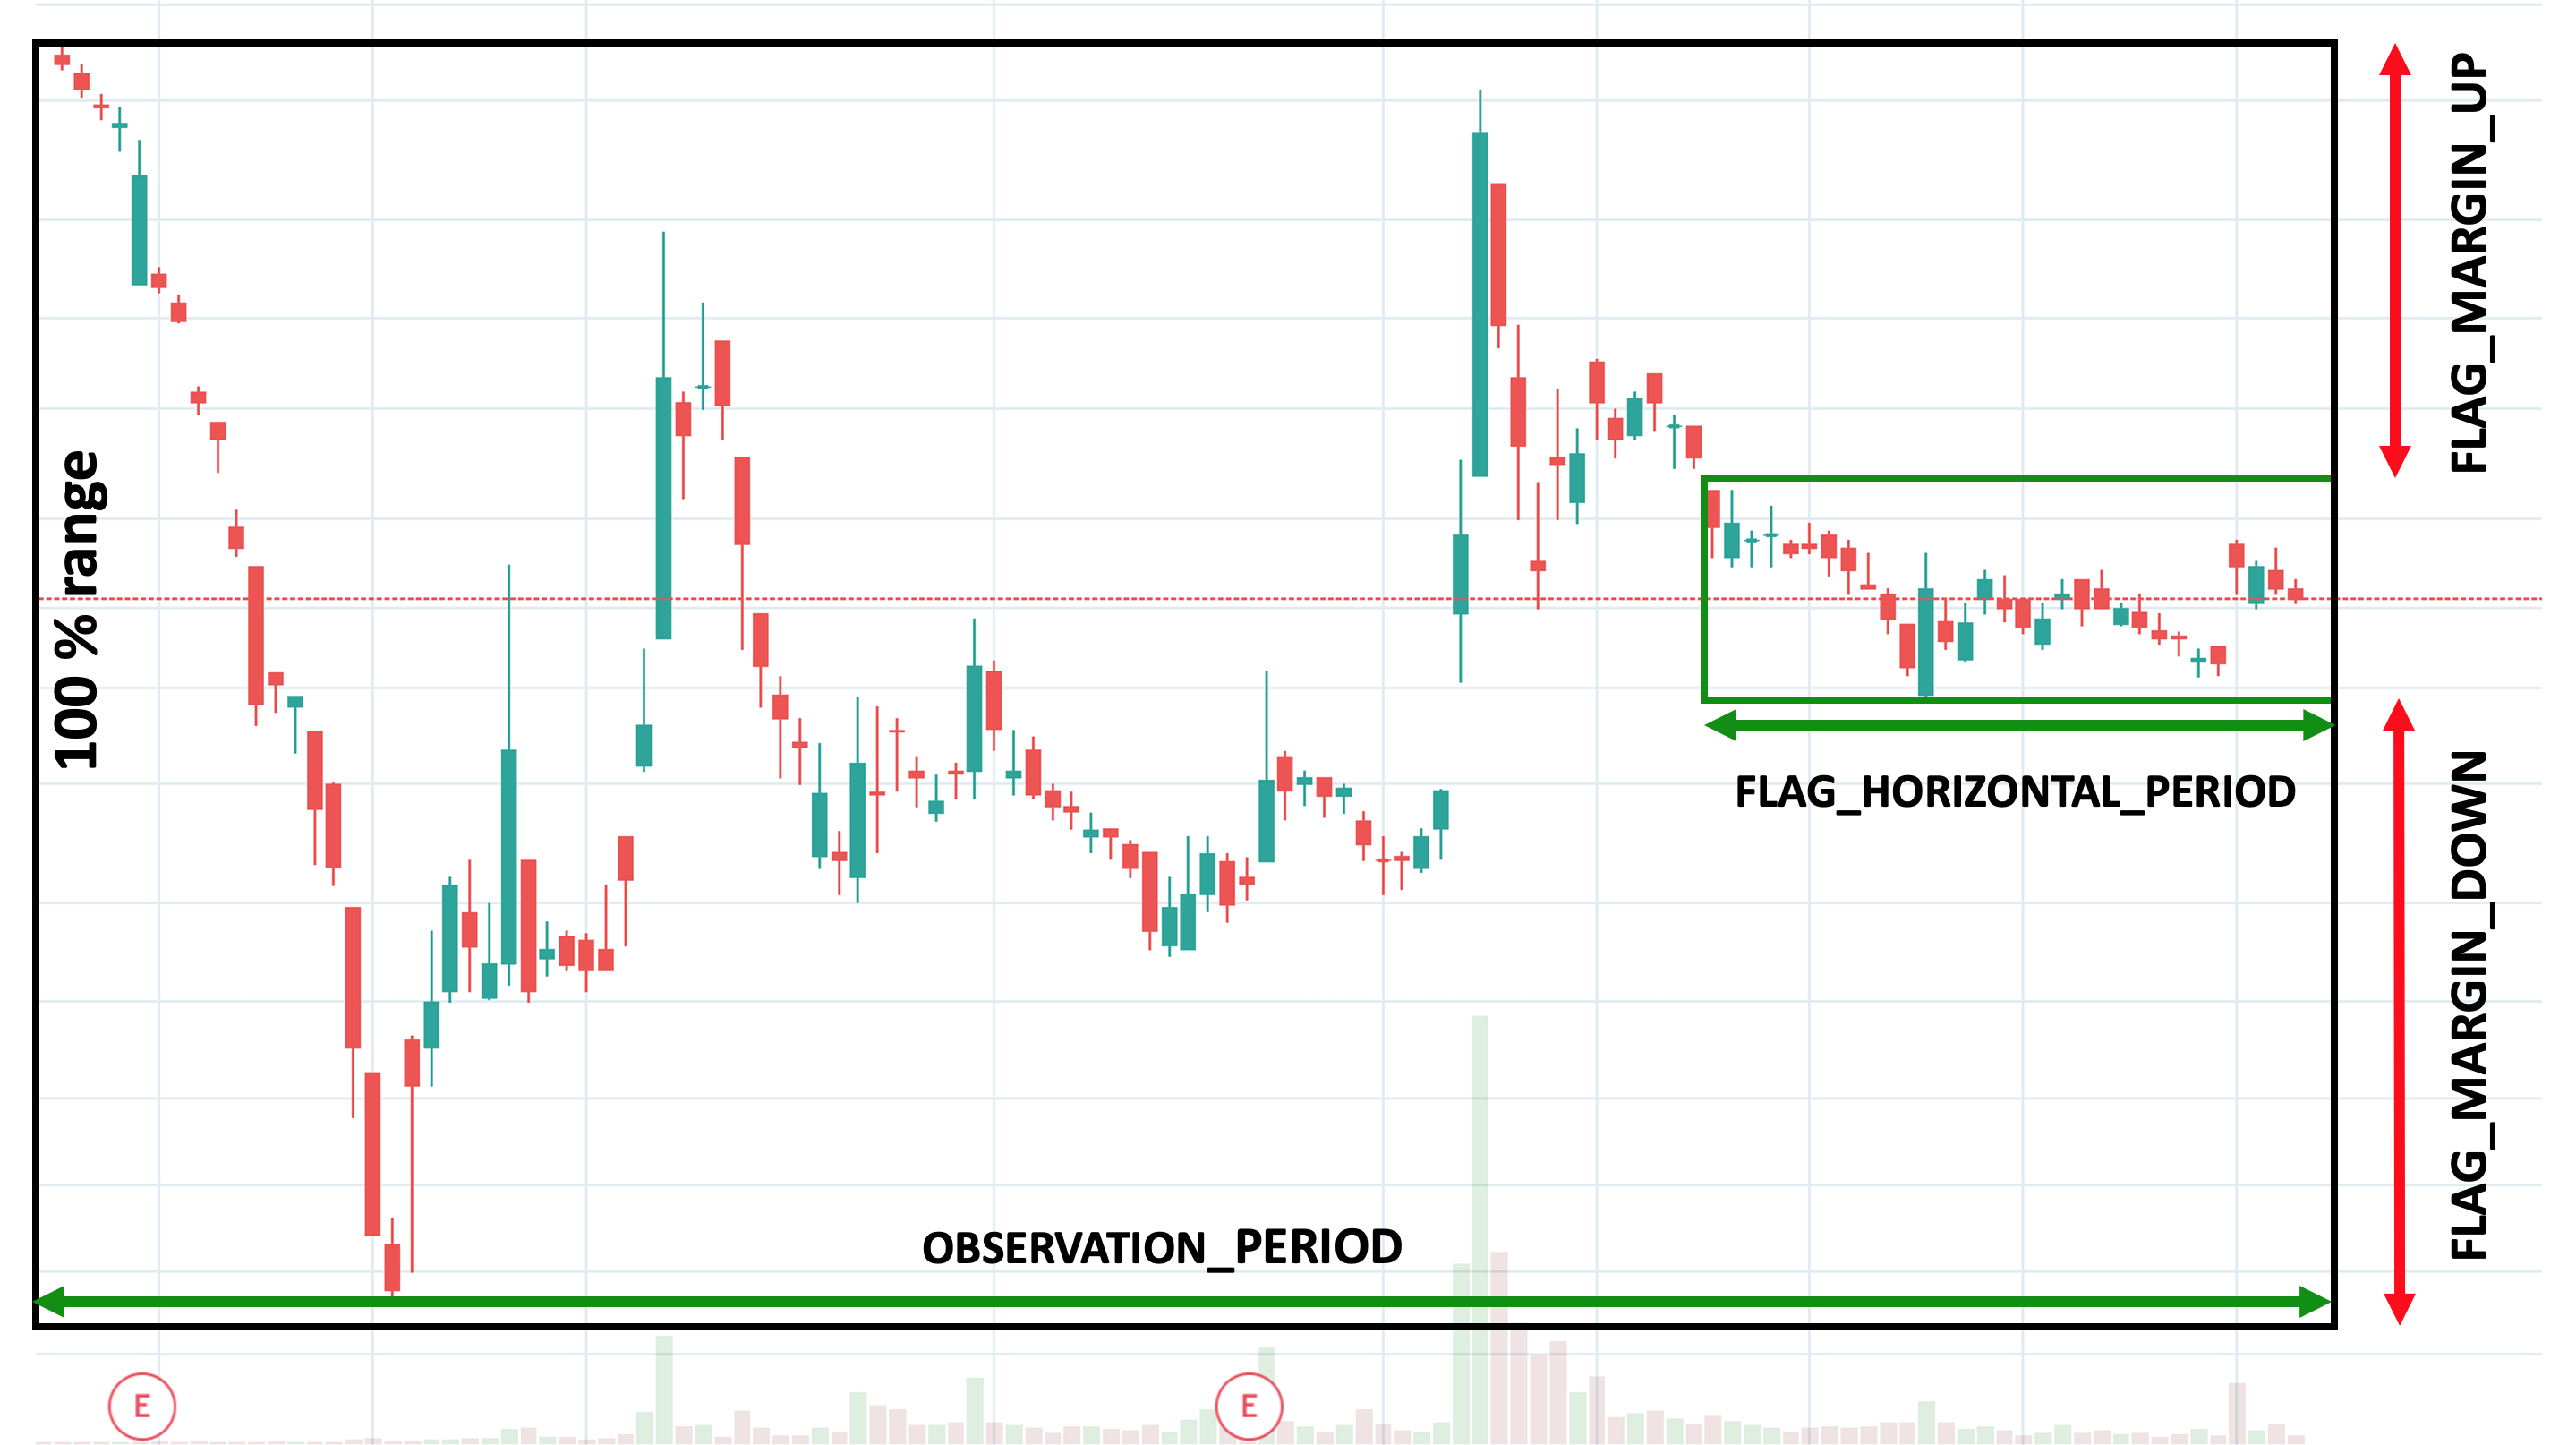

Pattern analysis on: MMM

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 78 

DatetimeIndex(['2012-02-07', '2012-02-08', '2012-02-09', '2012-02-10',
               '2012-02-13', '2012-02-14', '2012-02-15', '2012-02-16',
               '2012-02-17', '2012-02-21', '2012-02-22', '2012-02-23',
               '2012-02-24', '2012-02-27', '2012-02-28', '2012-02-29',
               '2012-03-01', '2012-03-20', '2012-03-21', '2013-02-14',
               '2013-02-15', '2013-03-12', '2013-03-13', '2013-03-14',
               '2013-03-15', '2013-03-18', '2013-04-02', '2013-04-03',
               '2013-04-04', '2013-05-16', '2013-05-20', '2013-05-21',
               '2013-05-22', '2013-11-20', '2013-11-21', '2014-11-17',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-24',
               '2014-11-25', '2014-12-29', '2014-12-30', '2015-02-19',
               '2015-02-20', '2015-02-23', '2015-02-27', '2015-03-02',
               '2015-03-03', '2016-03-08', '2016-03-0

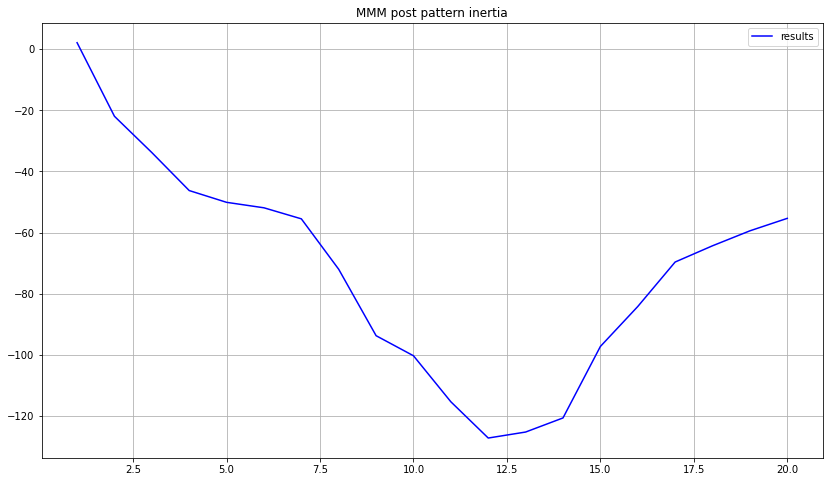

2019-04-24 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: AXP

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 34 

DatetimeIndex(['2012-02-24', '2012-03-22', '2012-03-23', '2013-04-02',
               '2013-05-09', '2013-05-10', '2013-12-30', '2014-12-30',
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-27',
               '2016-12-28', '2017-02-09', '2017-02-10', '2017-02-16',
               '2017-02-17', '2017-02-21', '2017-02-22', '2017-02-23',
               '2017-02-24', '2017-02-27', '2017-02-28', '2017-10-06',
               '2017-10-09', '2017-10-10', '2017-10-12', '2017-10-13',
               '2018-01-10', '2018-01-11', '2018-01-12', '2019-05-02',
               '2019-05-07', '2019-05-08'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.75 average of 0.02 with 18 winning trades and 16 loosing trades
After: 2 days: 2.47 average of 0.07 with 17 winning trades and 17 loosing trades
After: 

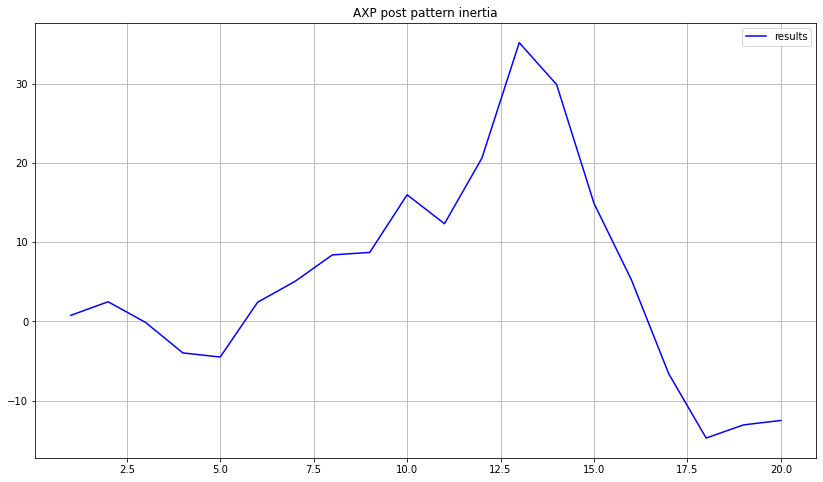

2019-05-08 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: AAPL

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 96 

DatetimeIndex(['2010-11-10', '2010-11-11', '2010-12-09', '2010-12-10',
               '2010-12-13', '2010-12-14', '2010-12-15', '2010-12-16',
               '2010-12-17', '2010-12-20', '2010-12-21', '2010-12-22',
               '2010-12-23', '2010-12-27', '2010-12-28', '2010-12-29',
               '2010-12-30', '2010-12-31', '2011-01-03', '2012-03-23',
               '2012-03-26', '2012-03-27', '2012-04-02', '2012-04-10',
               '2012-04-11', '2012-04-12', '2012-09-20', '2012-09-21',
               '2014-08-25', '2014-08-26', '2014-08-27', '2014-08-28',
               '2014-08-29', '2014-09-02', '2017-01-24', '2017-02-22',
               '2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28',
               '2017-03-06', '2017-03-07', '2017-03-08', '2017-03-09',
               '2017-03-10', '2017-03-13', '2017-03-14', '2017-

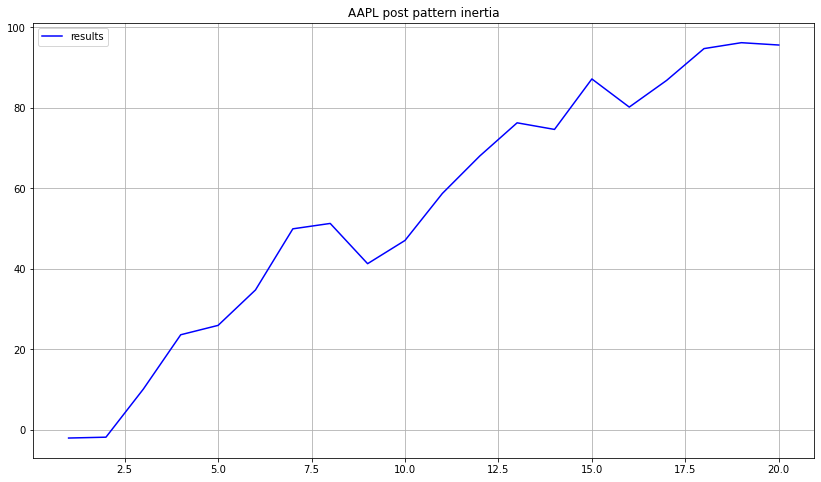

2020-07-22 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: BA

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 68 

DatetimeIndex(['2011-12-29', '2011-12-30', '2012-01-13', '2012-01-17',
               '2012-01-18', '2012-01-19', '2012-01-20', '2012-01-23',
               '2012-01-24', '2012-02-21', '2012-02-22', '2012-02-23',
               '2012-02-24', '2012-02-27', '2013-05-10', '2013-05-13',
               '2013-05-31', '2013-06-03', '2013-06-04', '2013-06-13',
               '2013-06-14', '2013-06-17', '2013-10-30', '2013-11-12',
               '2013-11-13', '2015-02-17', '2015-11-05', '2015-11-25',
               '2017-01-10', '2017-01-11', '2017-03-07', '2017-03-08',
               '2017-09-25', '2017-09-26', '2017-09-27', '2017-09-28',
               '2017-09-29', '2017-10-02', '2017-10-03', '2017-10-04',
               '2017-10-05', '2017-10-06', '2017-10-09', '2017-10-10',
               '2017-10-11', '2017-10-12', '2017-10-13', '2017-10

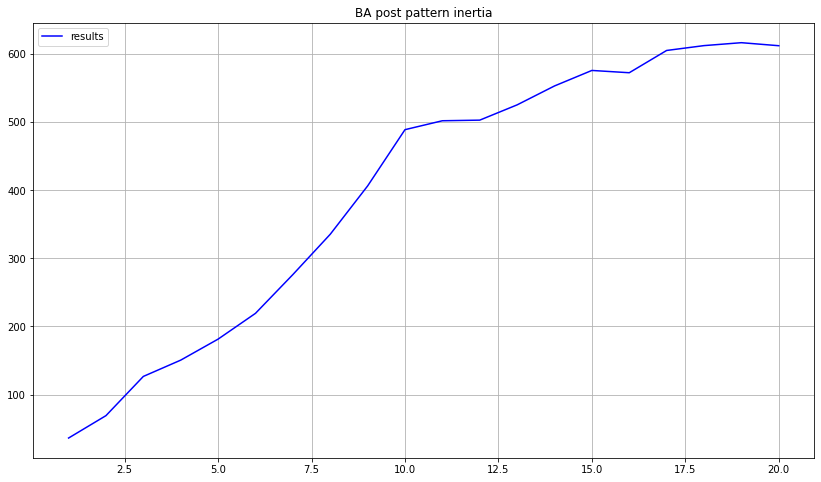

2019-02-22 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: CAT

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 69 

DatetimeIndex(['2010-09-30', '2010-11-11', '2010-12-20', '2010-12-21',
               '2010-12-22', '2010-12-23', '2010-12-27', '2010-12-28',
               '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-03',
               '2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13',
               '2011-01-14', '2011-02-09', '2011-02-10', '2011-04-05',
               '2011-04-06', '2012-02-09', '2012-02-10', '2012-02-13',
               '2012-02-14', '2012-02-15', '2012-02-16', '2012-02-17',
               '2012-02-21', '2012-02-22', '2012-02-23', '2012-02-24',
               '2012-02-27', '2012-02-28', '2012-02-29', '2012-03-01',
               '2013-02-05', '2017-08-01', '2017-08-29', '2017-09-22',
               '2017-09-25', '2017-09-26', '2017-09-27', '2017-0

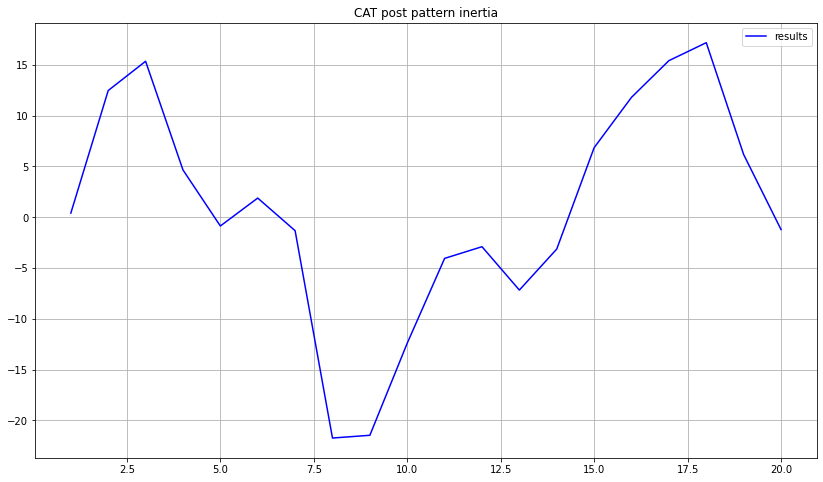

2020-07-30 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: CVX

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 29 

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-19', '2011-03-28',
               '2011-04-05', '2011-04-06', '2011-04-07', '2011-04-08',
               '2011-04-11', '2013-03-11', '2013-03-12', '2013-03-13',
               '2013-03-26', '2013-03-27', '2013-05-09', '2016-07-18',
               '2016-07-19', '2016-12-22', '2016-12-23', '2016-12-27',
               '2016-12-28', '2016-12-29', '2016-12-30', '2017-12-29',
               '2018-01-09', '2018-01-10', '2019-03-20', '2019-03-21',
               '2019-04-11'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -3.43 average of -0.12 with 12 winning trades and 17 loosing trades
After: 2 days: -4.32 average of -0.15 with 9 winning trades and 20 loosing trades
After: 3 days: -5.49 average of -0.19 with 11 winning trades and 18 loosing trades
After:

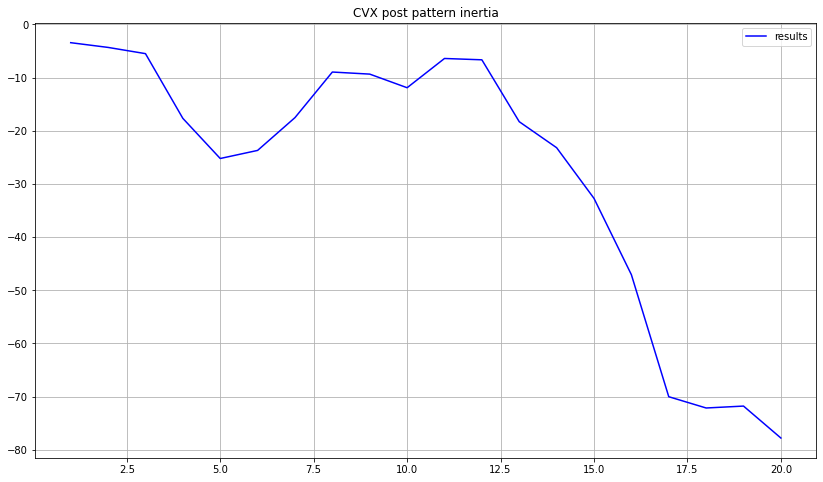

2019-04-11 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: CSCO

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 51 

DatetimeIndex(['2013-02-11', '2013-02-12', '2013-02-13', '2013-03-13',
               '2013-03-14', '2013-07-17', '2013-07-18', '2013-07-19',
               '2013-08-09', '2013-08-12', '2013-08-13', '2013-08-14',
               '2014-12-30', '2015-02-20', '2015-02-23', '2015-02-24',
               '2015-02-25', '2015-02-27', '2016-06-01', '2016-06-02',
               '2016-06-03', '2016-06-06', '2016-06-07', '2016-06-08',
               '2016-06-09', '2016-06-10', '2016-06-13', '2016-08-12',
               '2016-08-15', '2016-08-16', '2016-09-01', '2017-03-03',
               '2017-12-22', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2018-01-02', '2018-01-11', '2018-03-16',
               '2019-03-21', '2019-04-05', '2019-04-08', '2019-04-09',
               '2019-04-10', '2019-04-11', '2019-04-12', '2019-

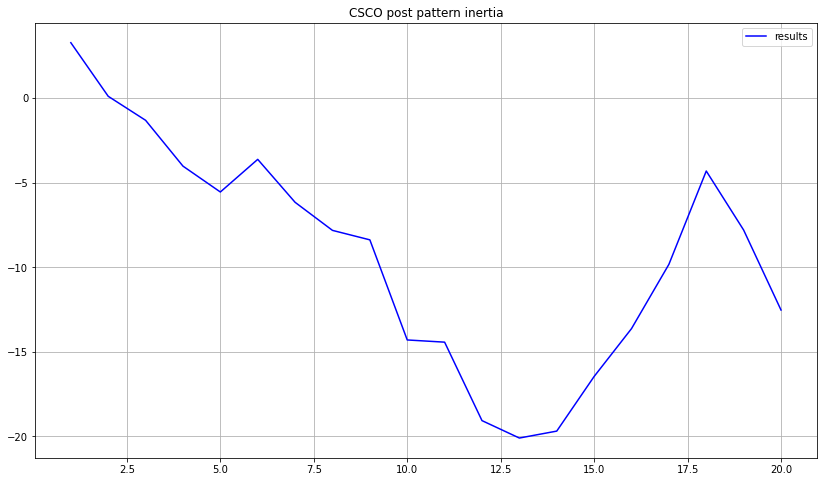

2019-04-25 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: KO

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 27 

DatetimeIndex(['2010-10-11', '2010-10-12', '2010-10-13', '2010-10-14',
               '2010-10-15', '2010-10-18', '2010-10-19', '2010-11-03',
               '2010-11-10', '2010-11-11', '2010-11-12', '2010-11-15',
               '2010-12-07', '2010-12-08', '2010-12-09', '2010-12-10',
               '2010-12-13', '2010-12-22', '2010-12-23', '2010-12-27',
               '2010-12-28', '2010-12-29', '2010-12-30', '2010-12-31',
               '2011-01-03', '2015-12-30', '2019-07-18'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.89 average of -0.03 with 17 winning trades and 10 loosing trades
After: 2 days: -1.62 average of -0.06 with 14 winning trades and 13 loosing trades
After: 3 days: 2.11 average of 0.08 with 17 winning trades and 10 loosing trades
After: 4 days: 1.95 average of 0.07 with 15 winning

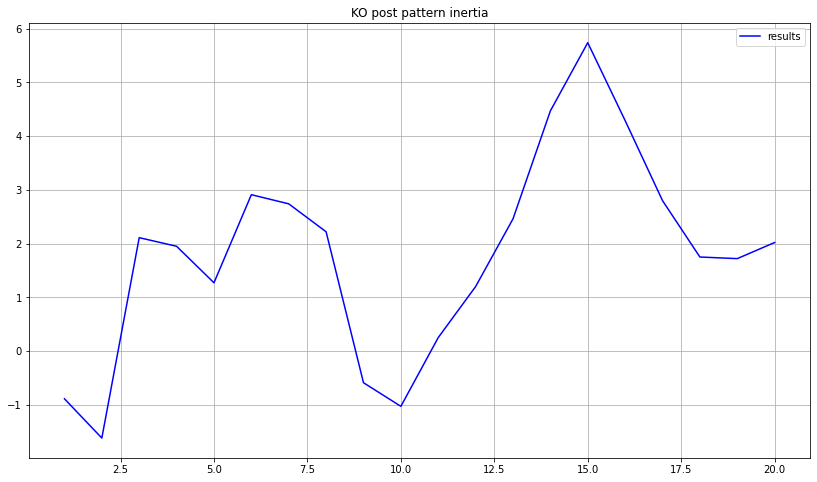

2019-07-18 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: XOM

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 40 

DatetimeIndex(['2010-12-08', '2010-12-09', '2010-12-10', '2010-12-13',
               '2010-12-14', '2010-12-15', '2010-12-16', '2010-12-17',
               '2010-12-20', '2010-12-21', '2010-12-22', '2010-12-23',
               '2010-12-27', '2010-12-28', '2010-12-29', '2010-12-30',
               '2010-12-31', '2011-01-10', '2011-01-11', '2011-02-08',
               '2011-02-09', '2011-12-30', '2012-01-09', '2012-01-10',
               '2012-02-28', '2012-08-17', '2012-09-27', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-26',
               '2016-05-27', '2016-05-31', '2016-06-13', '2016-06-14',
               '2016-06-15', '2016-07-18', '2016-07-19', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 6.45 average of 0.16 with 19 winning trades and 21 loos

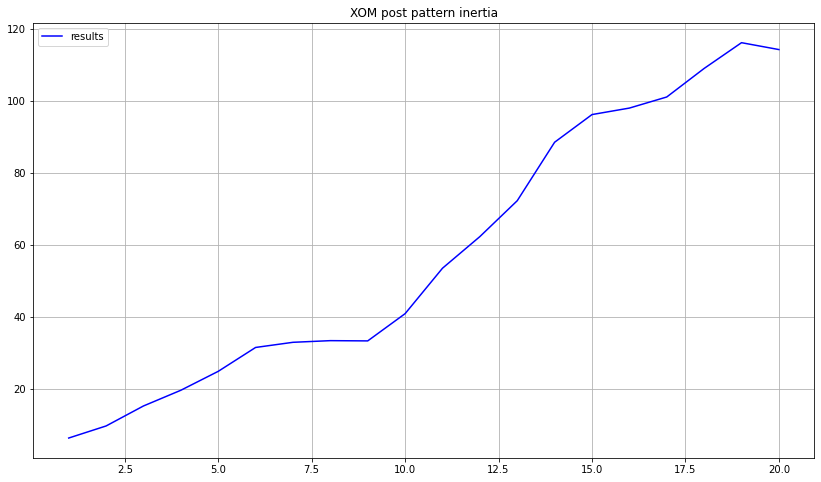

2017-12-29 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: GS

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 33 

DatetimeIndex(['2013-01-28', '2013-12-30', '2013-12-31', '2015-06-17',
               '2016-10-25', '2016-11-02', '2016-11-03', '2016-11-25',
               '2016-11-28', '2016-11-29', '2016-12-14', '2016-12-27',
               '2016-12-28', '2017-01-12', '2017-01-13', '2017-02-17',
               '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
               '2017-02-27', '2017-02-28', '2017-03-07', '2017-03-08',
               '2017-03-09', '2017-03-10', '2017-03-13', '2019-12-23',
               '2019-12-24', '2019-12-26', '2019-12-27', '2019-12-30',
               '2019-12-31'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -3.39 average of -0.1 with 17 winning trades and 16 loosing trades
After: 2 days: 0.57 average of 0.02 with 17 winning trades and 16 loosing trades
After: 3 days: 25.25 

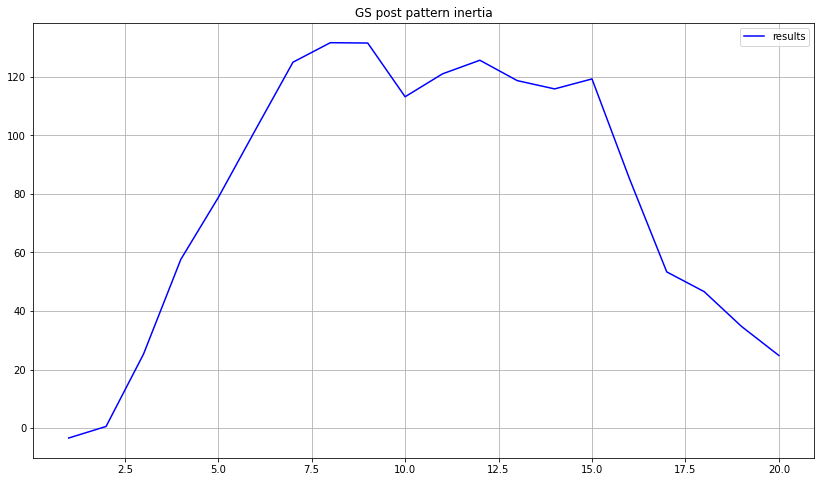

2019-12-31 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: HD

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 120 

DatetimeIndex(['2010-12-22', '2010-12-23', '2010-12-27', '2010-12-28',
               '2010-12-29', '2010-12-30', '2011-12-08', '2011-12-09',
               '2011-12-28', '2011-12-29',
               ...
               '2020-06-10', '2020-07-21', '2020-07-22', '2020-07-23',
               '2020-07-24', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31'],
              dtype='datetime64[ns]', name='Date', length=120, freq=None) 

After: 1 days: -7.79 average of -0.06 with 64 winning trades and 55 loosing trades
After: 2 days: -3.74 average of -0.03 with 68 winning trades and 50 loosing trades
After: 3 days: -12.96 average of -0.11 with 68 winning trades and 49 loosing trades
After: 4 days: -29.25 average of -0.24 with 74 winning trades and 42 loosing trades
After: 5 days: -38.13 average of -0.32 with 7

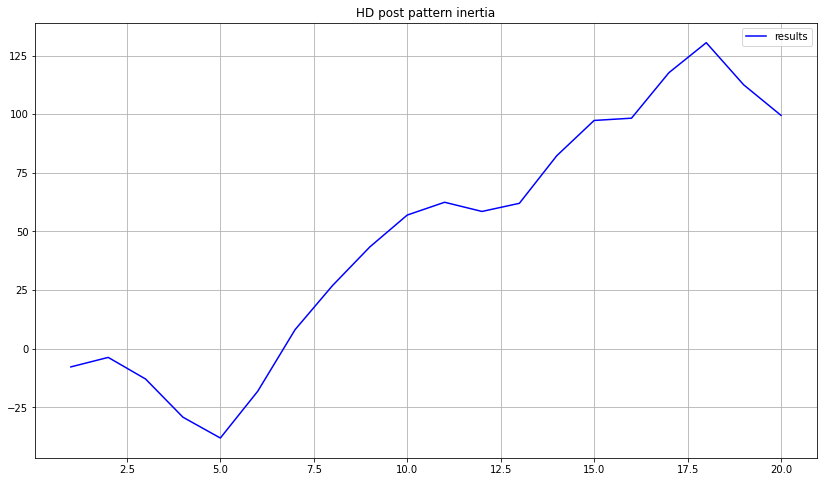

2020-07-31 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: IBM

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 36 

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-07', '2011-01-10',
               '2011-01-11', '2011-01-12', '2011-01-13', '2011-02-07',
               '2011-02-08', '2011-02-09', '2011-02-10', '2011-02-11',
               '2011-02-14', '2011-07-26', '2012-03-30', '2016-06-02',
               '2016-06-03', '2016-06-06', '2016-06-07', '2016-06-08',
               '2016-06-09', '2016-06-10', '2017-03-06', '2017-03-07',
               '2017-03-08', '2019-03-18', '2019-03-21', '2019-03-22',
               '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10',
               '2019-04-11', '2019-04-12', '2019-04-15', '2019-04-16'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -1.09 average of -0.03 with 17 winning trades and 19 loosing trades
After: 2 days: -6.93 average of -0.19 with 17 winning trad

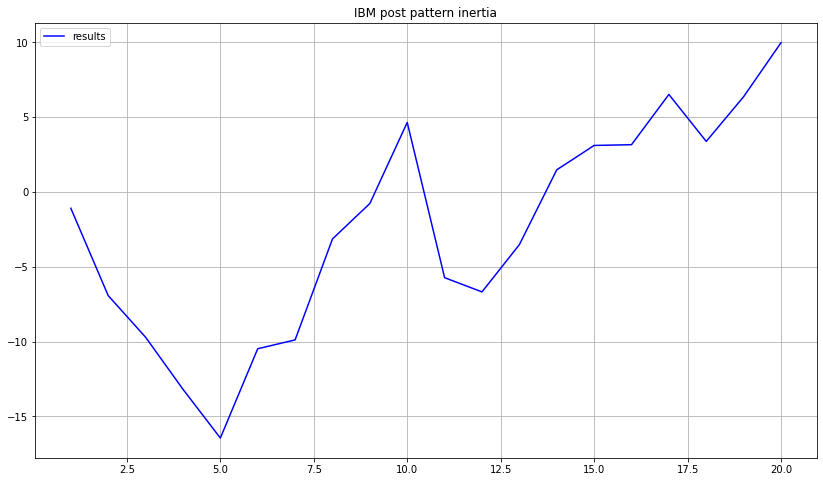

2019-04-16 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: INTC

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 41 

DatetimeIndex(['2012-01-27', '2012-01-30', '2012-01-31', '2012-02-01',
               '2012-02-02', '2012-02-07', '2012-02-08', '2012-02-09',
               '2012-02-10', '2012-02-13', '2012-02-14', '2012-02-15',
               '2012-02-16', '2012-03-21', '2012-03-22', '2012-03-23',
               '2014-06-19', '2014-06-20', '2014-06-23', '2014-07-01',
               '2014-07-02', '2014-07-03', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-28', '2014-07-29', '2014-07-30',
               '2014-07-31', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-09-02', '2014-09-03', '2014-09-04', '2014-09-05',
               '2015-12-30', '2016-07-19', '2019-12-30', '2019-12-31',
               '2020-01-03'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 3.32 average of 0.08 with

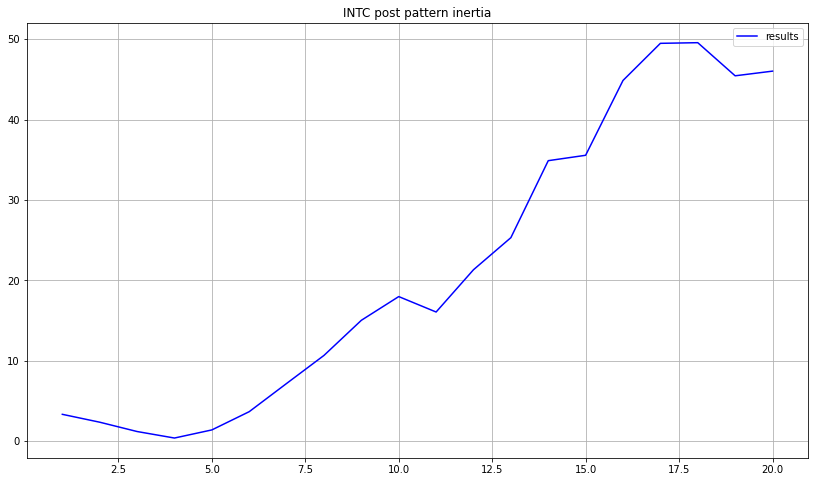

2020-01-03 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: JNJ

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 51 

DatetimeIndex(['2013-03-18', '2013-03-19', '2013-03-21', '2013-04-30',
               '2013-05-09', '2013-05-10', '2013-05-13', '2013-05-21',
               '2013-07-26', '2013-08-05', '2013-08-06', '2013-08-07',
               '2014-05-15', '2014-06-09', '2014-06-11', '2014-06-12',
               '2014-06-26', '2014-06-27', '2014-06-30', '2014-07-02',
               '2015-11-05', '2015-11-06', '2015-11-09', '2015-11-10',
               '2015-11-11', '2015-11-24', '2015-11-25', '2015-11-27',
               '2015-11-30', '2015-12-01', '2015-12-02', '2015-12-11',
               '2016-04-26', '2016-04-27', '2016-05-16', '2016-05-17',
               '2016-06-13', '2016-06-15', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-26', '2016-07-27',
               '2016-07-28', '2016-07-29', '2016-08-01', '2016-0

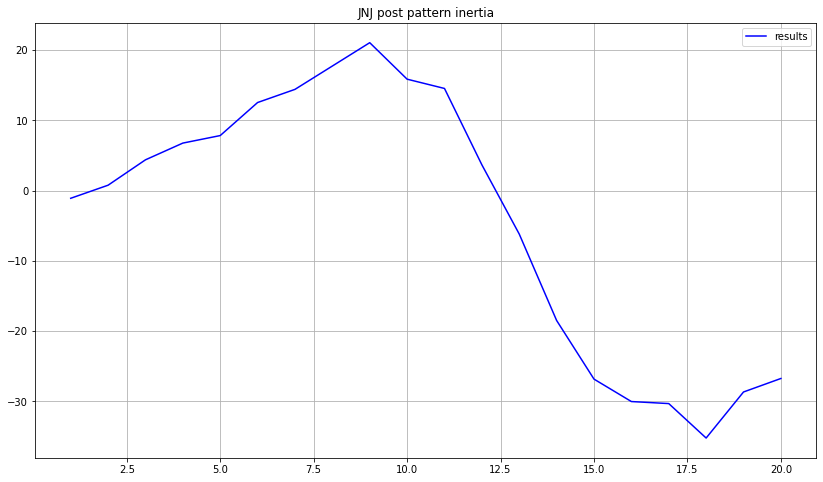

2018-09-19 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: JPM

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 40 

DatetimeIndex(['2012-02-09', '2012-03-22', '2012-03-23', '2012-03-30',
               '2012-04-02', '2012-04-03', '2013-01-24', '2013-02-11',
               '2013-07-25', '2013-12-30', '2013-12-31', '2014-01-02',
               '2015-06-16', '2015-06-17', '2015-06-26', '2015-07-21',
               '2016-12-27', '2016-12-28', '2017-01-12', '2017-02-22',
               '2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28',
               '2018-01-03', '2018-01-30', '2018-01-31', '2018-02-01',
               '2019-11-22', '2019-11-29', '2019-12-02', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30', '2019-12-31', '2020-01-02'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 4.21 average of 0.11 with 24 winning trades and 16 loos

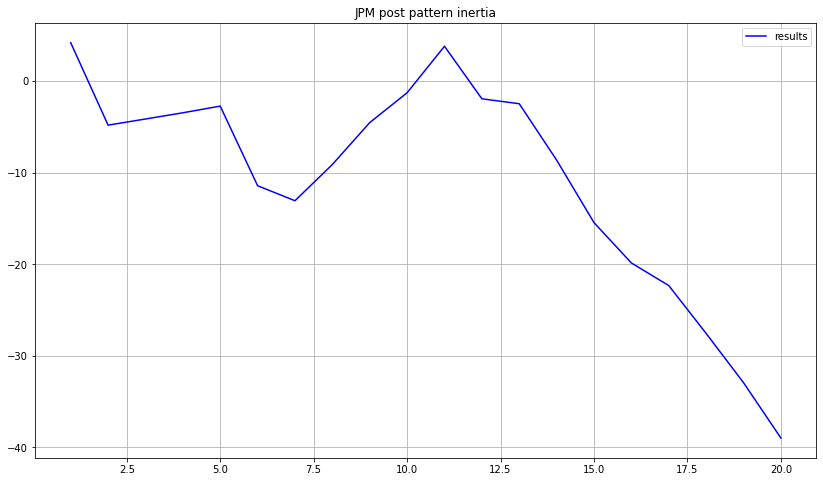

2020-01-02 00:00:00
2020-11-08 00:00:00
No patterns today!

Pattern analysis on: MCD

Flag_Upper_position: 100 Flag_Lower_position: 90 

Occurrences: 76 

DatetimeIndex(['2010-10-11', '2010-11-10', '2010-11-11', '2011-07-11',
               '2011-07-12', '2013-03-14', '2013-03-15', '2013-03-18',
               '2013-03-19', '2013-03-20', '2013-03-21', '2013-03-22',
               '2013-03-25', '2013-03-26', '2013-03-27', '2015-11-25',
               '2015-11-27', '2015-11-30', '2015-12-01', '2015-12-02',
               '2015-12-03', '2015-12-11', '2015-12-14', '2015-12-21',
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-28',
               '2015-12-30', '2015-12-31', '2016-12-23', '2016-12-27',
               '2017-03-23', '2017-03-24', '2017-03-27', '2017-03-28',
               '2017-03-29', '2017-03-30', '2017-03-31', '2017-04-03',
               '2017-04-04', '2017-05-11', '2017-05-12', '2017-05-22',
               '2017-05-23', '2017-05-25', '2017-06-01', '2017-0

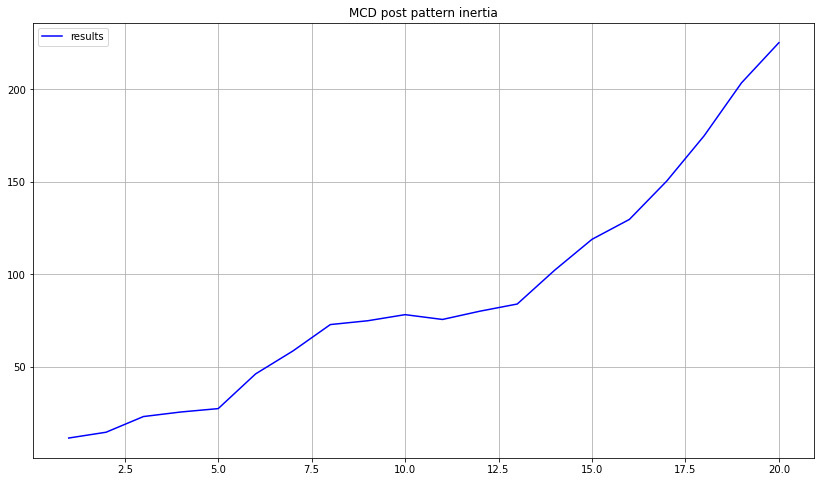

2020-07-29 00:00:00
2020-11-08 00:00:00
No patterns today!

Basket Analysis:
Positive inertia after 1 bars: ['MMM', 'AXP', 'BA', 'CAT', 'CSCO', 'XOM', 'INTC', 'JPM', 'MCD']
Positive inertia after 2 bars: ['AXP', 'BA', 'CAT', 'CSCO', 'XOM', 'GS', 'INTC', 'JNJ', 'MCD']
Positive inertia after 3 bars: ['AAPL', 'BA', 'CAT', 'KO', 'XOM', 'GS', 'INTC', 'JNJ', 'MCD']
Positive inertia after 4 bars: ['AAPL', 'BA', 'CAT', 'KO', 'XOM', 'GS', 'INTC', 'JNJ', 'MCD']
Positive inertia after 5 bars: ['AAPL', 'BA', 'KO', 'XOM', 'GS', 'INTC', 'JNJ', 'MCD']
Positive inertia after 6 bars: ['AXP', 'AAPL', 'BA', 'CAT', 'KO', 'XOM', 'GS', 'INTC', 'JNJ', 'MCD']
Positive inertia after 7 bars: ['AXP', 'AAPL', 'BA', 'KO', 'XOM', 'GS', 'HD', 'INTC', 'JNJ', 'MCD']
Positive inertia after 8 bars: ['AXP', 'AAPL', 'BA', 'KO', 'XOM', 'GS', 'HD', 'INTC', 'JNJ', 'MCD']
Positive inertia after 9 bars: ['AXP', 'AAPL', 'BA', 'XOM', 'GS', 'HD', 'INTC', 'JNJ', 'MCD']
Positive inertia after 10 bars: ['AXP', 'AAPL', 'BA', 'XOM', '

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,basket
1,2.11,0.75,-2.05,36.10,0.41,-3.43,3.28,-0.89,6.45,-3.39,-7.79,-1.09,3.32,-1.10,4.21,11.45,3.021250
2,-21.96,2.47,-1.84,68.99,12.48,-4.32,0.11,-1.62,9.80,0.57,-3.74,-6.93,2.34,0.76,-4.80,14.59,4.181250
3,-33.82,-0.13,10.11,126.57,15.36,-5.49,-1.31,2.11,15.35,25.25,-12.96,-9.71,1.18,4.37,-4.13,23.07,9.738750
4,-46.24,-3.99,23.61,150.50,4.66,-17.66,-4.02,1.95,19.71,57.65,-29.25,-13.19,0.37,6.75,-3.45,25.53,10.808125
5,-50.09,-4.51,25.94,181.37,-0.86,-25.21,-5.55,1.27,24.96,78.74,-38.13,-16.45,1.38,7.82,-2.72,27.36,12.832500
6,-51.88,2.41,34.74,219.21,1.89,-23.69,-3.62,2.91,31.59,101.99,-18.18,-10.48,3.65,12.52,-11.42,46.13,21.110625
7,-55.49,5.04,49.93,276.14,-1.32,-17.52,-6.16,2.74,33.02,125.00,8.11,-9.89,7.16,14.39,-13.06,58.55,29.790000
8,-71.99,8.39,51.27,335.33,-21.74,-8.95,-7.82,2.22,33.48,131.67,26.88,-3.14,10.65,17.71,-9.10,72.81,35.479375
9,-93.70,8.70,41.27,406.27,-21.47,-9.34,-8.38,-0.59,33.41,131.55,43.39,-0.77,15.02,21.03,-4.52,74.87,39.796250
10,-100.26,15.98,47.04,488.96,-12.40,-11.90,-14.30,-1.03,40.97,113.20,56.97,4.65,17.97,15.84,-1.26,78.17,46.162500


In [12]:
import datetime

OBSERVATION_PERIOD = 100
FLAG_HORIZONTAL_PERIOD = 5
FLAG_MARGIN_UP = 0
FLAG_MARGIN_DOWN = 90

if FLAG_MARGIN_UP + FLAG_MARGIN_DOWN >= 100:
    print("Estensione Flag incongruente: verifica (FLAG_MARGIN_UP + FLAG_MARGIN_DOWN) <= 100")

basket_results = pd.DataFrame(index = range(1, days_after + 1))

for ticker in tickerlist.split(","):

    print("Pattern analysis on: " + ticker + "\n")

    dataset = create_asset_dataset(matrix)
    
    # Calcoliamo il livello massimo di osservazione
    Observation_Highest_High = dataset.high.rolling(OBSERVATION_PERIOD).max()
    
    # Calcoliamo il livello minimo di osservazione
    Observation_Lowest_Low = dataset.low.rolling(OBSERVATION_PERIOD).min()
    
    # Calcoliamo l'escursione dell'intera osservazione
    Excursion = Observation_Highest_High - Observation_Lowest_Low

    # Calcoliamo la percentuale superiore ed inferiore che circoscrive il flag
    Flag_Upper_position = 100 - FLAG_MARGIN_UP
    Flag_Lower_position = FLAG_MARGIN_DOWN

    # Calcoliamo il livello di prezzo superiore del flag
    Flag_Upper_level = Observation_Lowest_Low + Excursion * Flag_Upper_position / 100
    
    # Calcoliamo il livello di prezzo inferiore del flag
    Flag_Lower_level = Observation_Lowest_Low + Excursion * Flag_Lower_position / 100

    print("Flag_Upper_position:", Flag_Upper_position, "Flag_Lower_position:", Flag_Lower_position, "\n")
    #print("Flag_Upper_level:", Flag_Upper_level, "Flag_Lower_level:", Flag_Lower_level)

    pattern = (dataset.high.rolling(FLAG_HORIZONTAL_PERIOD).max() <= Flag_Upper_level) &\
              (dataset.low.rolling(FLAG_HORIZONTAL_PERIOD).min() >= Flag_Lower_level)
    
    results = pattern_stats(dataset, pattern, "long", days_after, ticker)
    
    last_result_date = pattern[pattern == True].index[-1]
    print(last_result_date)
    
    today = pd.to_datetime(datetime.datetime.now().date()) - pd.Timedelta(days = 8)
    print(today)
    
    if (last_result_date == today):
        print("Pattern present on last sample:", last_result_date)
    else:
        print("No patterns today!")
    
    if show_patterns == True:
        plot_patterns(dataset,results[0])
        
    basket_results[ticker] = results[1]
        
    print("")
    
print("Basket Analysis:")
positive_effect(basket_results)
    
basket_results["basket"] = basket_results.mean(axis = 1)
basket_results

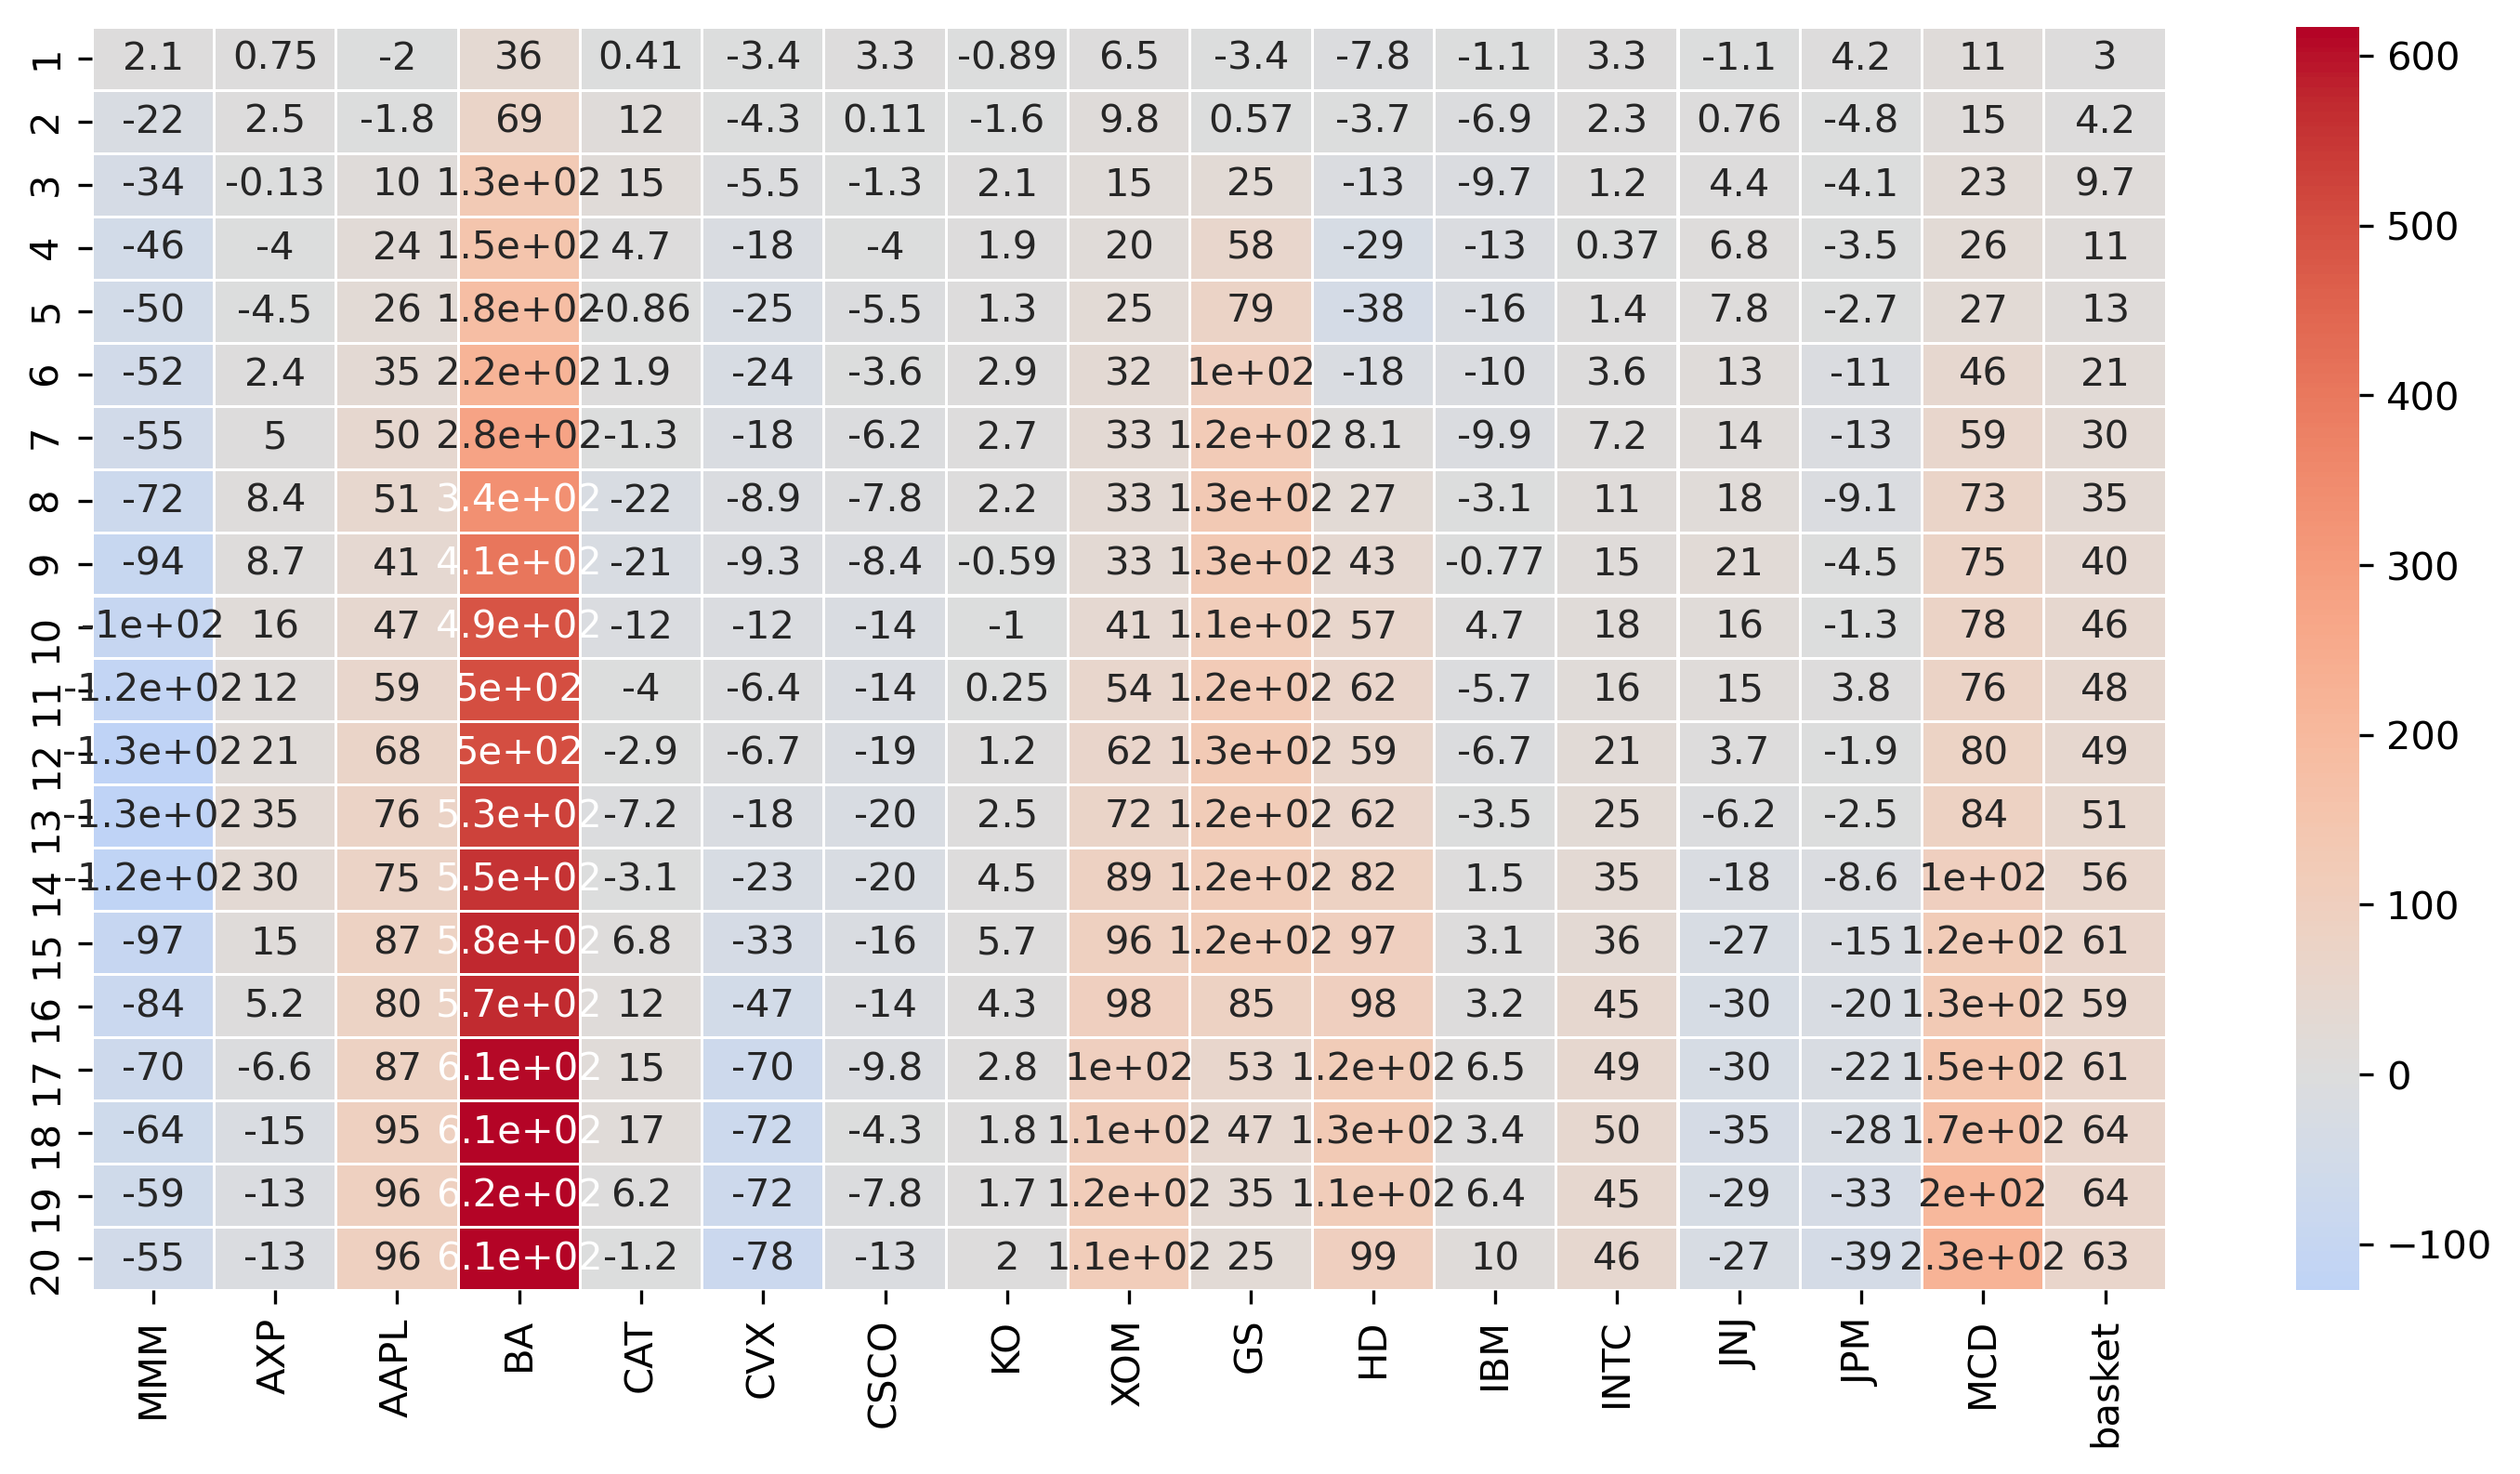

In [13]:
import seaborn as sns
plt.figure(figsize = [12,6], dpi = 300)
plt.xticks(rotation = 90)
ax = sns.heatmap(basket_results, annot=True, cmap="coolwarm", center = 0, linewidths=.5)

In [14]:
basket_results.iplot(title = "Pattern inertia")